FRAUD DETECTION USING GCLOUD.

In [1]:
#Importing the required libraries

import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import explainable_ai_sdk

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder

In [2]:
# Download the Kaggle Synthetic Dataset using gsutil command.

!gsutil cp gs://financial_fraud_detection/fraud_data_kaggle.csv .

Copying gs://financial_fraud_detection/fraud_data_kaggle.csv...
\ [1 files][303.4 MiB/303.4 MiB]                                                
Operation completed over 1 objects/303.4 MiB.                                    


In [3]:
# Read the downloaded data in jupyter notebook.

data = pd.read_csv('fraud_data_kaggle.csv')
data = data.drop(columns=['type'])
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [4]:
# Down Sampling the Data so that we have a balanced dataset with 75-25 percent ratio of Non-fraud vs Fraud respectively.

fraud = data[data['isFraud'] == 1]
not_fraud = data[data['isFraud'] == 0]

In [5]:
# Take random 75% of data from Not fraud dataset

print(not_fraud.shape)
not_fraud_sample=not_fraud.sample(random_state=2, frac=.005 )
print(not_fraud_sample.shape)

(4103092, 10)
(20515, 10)


In [6]:
# Put them back together and shuffle them

df=pd.concat([not_fraud_sample,fraud])
df=shuffle(df,random_state=2)


In [7]:
# Drop redundant columns

df=df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])
df.head()
print(df.shape)

(23926, 7)


In [8]:
# Now we split our datd set into traing and testing datasets

#Storing 80% of rows' index which will help us in slicling the dataset.
train_test_split = int(len(df) * .8)

train_set = df[:train_test_split]
test_set = df[train_test_split:]

train_labels = train_set.pop('isFraud')
test_labels = test_set.pop('isFraud')


In [9]:
# Next step is to Normalize the data using Standard Scalar

scaler = StandardScaler()
train_set = scaler.fit_transform(train_set) # Only normalize on the train set
test_set = scaler.transform(test_set)

# clip() ensures all values fall within the range [-5,5]
# useful if any outliers remain after normalizing
train_set = np.clip(train_set, -5, 5)
test_set = np.clip(test_set, -5, 5)

In [10]:
#Now we need to define a class weight for the dataset
#The Keras class_weight parameter lets us specify exactly how much weight we want to give examples from each class, based on how often they occur in the dataset:

weight_for_non_fraud = 1.0 / df['isFraud'].value_counts()[0]
weight_for_fraud = 1.0 / df['isFraud'].value_counts()[1]

class_weight = {0: weight_for_non_fraud, 1: weight_for_fraud}


In [11]:
# Train and Evaluate the model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS):
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_set.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [12]:
EPOCHS = 100
BATCH_SIZE = 512

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                112       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Training....

results = model.fit(
    train_set,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(test_set, test_labels),
    class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 19140 samples, validate on 4786 samples
Epoch 1/100
19140/19140 [==============================] - 4s 205us/sample - loss: 6.4983e-05 - tp: 1887.0000 - fp: 11415.0000 - tn: 5016.0000 - fn: 822.0000 - accuracy: 0.3607 - precision: 0.1419 - recall: 0.6966 - auc: 0.4927 - val_loss: 6.0874e-05 - val_tp: 586.0000 - val_fp: 2839.0000 - val_tn: 1245.0000 - val_fn: 116.0000 - val_accuracy: 0.3826 - val_precision: 0.1711 - val_recall: 0.8348 - val_auc: 0.5719
Epoch 2/100
19140/19140 [==============================] - 0s 22us/sample - loss: 6.0310e-05 - tp: 1774.0000 - fp: 9664.0000 - tn: 6767.0000 - fn: 935.0000 - accuracy: 0.4462 - precision: 0.1551 - recall: 0.6549 - auc: 0.5615 - val_loss: 5.7124e-05 - val_tp: 501.0000 - val_fp: 2076.0000 - val_tn: 2008.0000 - val_fn: 201.0000 - val_accuracy: 0.5242 - val_precision: 0.1944 - val_recall: 0.7137 - val_auc: 0.6499
Epoch 3/100
19140/19140 [==============================] - 0s 20us/sample

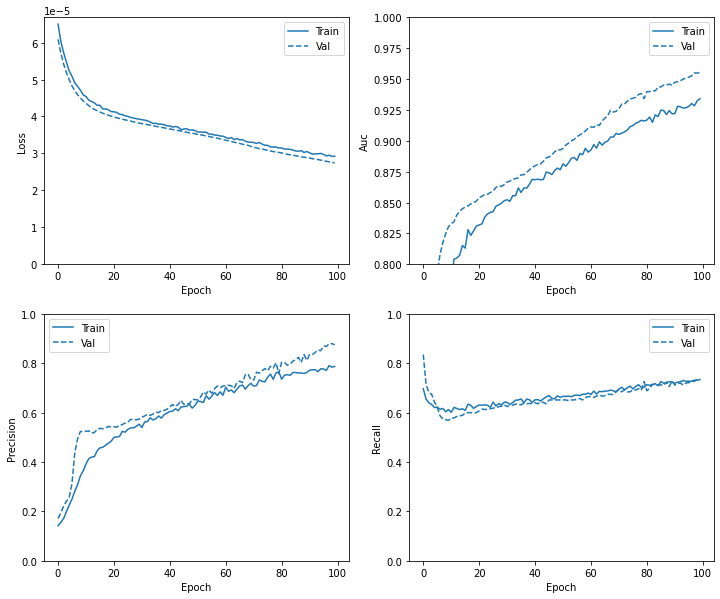

In [15]:
# Now, lets plot the metrics and visualize it.

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(results)

In [16]:
# Printing the Confusion Matrix. It will help us to know the false positives and negatives as well as true positives and negatives.

predicted = model.predict(test_set)

y_pred = []

for i in predicted.tolist():
  y_pred.append(int(round(i[0])))

In [17]:
cm = confusion_matrix(test_labels.values, y_pred)
print(cm)

[[4010   74]
 [ 187  515]]


In [18]:
# Visualizze it even better we can plot it using confusion matrix library

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

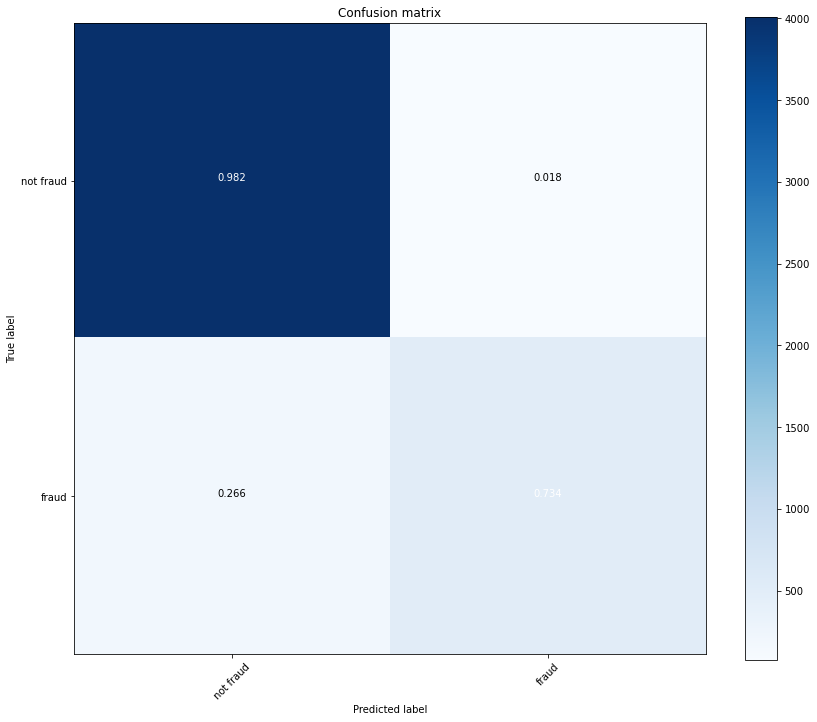

In [19]:
classes = ['not fraud', 'fraud']
plot_confusion_matrix(cm, classes, normalize=True)

In [20]:
# Let's export our trained model.

model_dir = 'fraud_model'
tf.saved_model.save(model, model_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: fraud_model/assets


In [21]:
#Getting metedata from the sdk model

model_builder = SavedModelMetadataBuilder(model_dir)
metadata = model_builder.get_metadata()
print(metadata)

{'outputs': OrderedDict([('dense_1', {'output_tensor_name': 'dense_1'})]), 'inputs': OrderedDict([('dense_input', {'input_tensor_name': 'dense_input', 'encoding': 'identity', 'modality': 'numeric'})]), 'framework': 'tensorflow2', 'tags': ['explainable_ai_sdk']}


In [22]:
# we have to set a baseline so that we can compare it with the value which is generated by explainable sdk.
# Thus, we calculate the median of non-fraudlent transactions as out baseline reference.

not_fraud_sample = not_fraud_sample.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud', 'isFraud'])

baseline = scaler.transform(not_fraud_sample.values)
baseline = np.clip(baseline, -5, 5)
baseline_values = np.median(baseline, axis=0)

In [23]:
input_name = list(metadata['inputs'])[0]
model_builder.set_numeric_metadata(input_name, input_baselines=[baseline_values.tolist()], index_feature_mapping=df.columns.tolist()[:6])
model_builder.save_metadata(model_dir)

In [24]:
# Getting model explanations

local_model = explainable_ai_sdk.load_model_from_local_path(
    model_dir, 
    explainable_ai_sdk.SampledShapleyConfig()
)

Label Index 0
Example Score: 0.9715
Baseline Score: 0.2952
Approximation Error: 0.0316


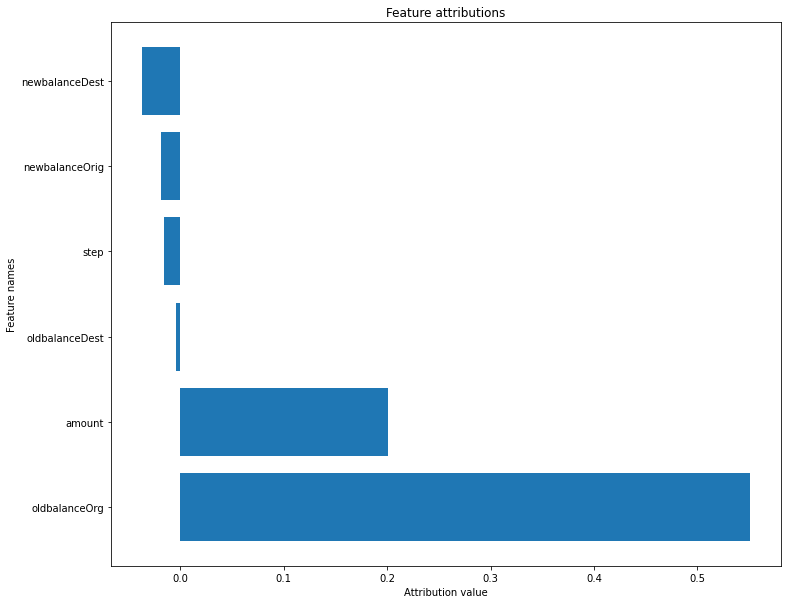

In [25]:
# Run an example which should be classified as fraudlent transaction

fraud_example = [0.722,0.139,-0.114,-0.258,-0.271,-0.305]
response = local_model.explain([{input_name: fraud_example}])
response[0].visualize_attributions()

In [26]:
local_model = explainable_ai_sdk.load_model_from_local_path(
    model_dir, 
    explainable_ai_sdk.SampledShapleyConfig(path_count=20)
)

In [27]:
# The Last step is to deploy the model to Cloud AI Platform

# Update these to your own GCP project and model
GCP_PROJECT = 'fraud-detection-297006'
MODEL_BUCKET = 'gs://fraud-detection-297006'

In [28]:
# Now, create a bucket on GCP.

!gsutil mb $MODEL_BUCKET

Creating gs://fraud-detection-297006/...


In [29]:
#Copy our local directory into the bucket.

!gsutil -m cp -r ./$model_dir/* $MODEL_BUCKET/explanations

Copying file://./fraud_model/explanation_metadata.json [Content-Type=application/json]...
Copying file://./fraud_model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./fraud_model/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://./fraud_model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
/ [4/4 files][128.0 KiB/128.0 KiB] 100% Done                                    
Operation completed over 4 objects/128.0 KiB.                                    


In [30]:
# Deploy the model

MODEL = 'fraud_detection'
VERSION = 'v1'
model_path = MODEL_BUCKET + '/explanations'

In [31]:
# Creating model...

!gcloud ai-platform models create $MODEL

Using endpoint [https://ml.googleapis.com/]

Learn more about regional endpoints and see a list of available regions: https://cloud.google.com/ai-platform/prediction/docs/regional-endpoints
ERROR: (gcloud.ai-platform.models.create) Resource in projects [fraud-detection-297006] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name


In [32]:
!gcloud beta ai-platform versions create $VERSION \
--model $MODEL \
--origin $model_path \
--runtime-version 2.1 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method 'sampled-shapley' \
--num-paths 10

Using endpoint [https://ml.googleapis.com/]
Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.
ERROR: (gcloud.beta.ai-platform.versions.create) ALREADY_EXISTS: Field: version.name Error: A version with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A version with the same name already exists.
    field: version.name


In [ ]:
# Confirm that the model has been deployed

!gcloud ai-platform versions describe $VERSION --model $MODEL

In [ ]:
# Getting predictions..

fraud_indices = []

for i,val in enumerate(test_labels):
    if val == 1:
        fraud_indices.append(i)

In [ ]:
num_test_examples = 5

instances = []
for i in range(num_test_examples):
    ex = test_set[fraud_indices[i]]
    instances.append({input_name: ex.tolist()})

In [ ]:
# We can send these five examples to our model using the SDK. First, we'll create a reference to our deployed model:

deployed_model = explainable_ai_sdk.load_model_from_ai_platform(GCP_PROJECT, MODEL, VERSION)

In [ ]:
#Then, we'll get explanations on those examples:

explanations = deployed_model.explain(instances)

In [ ]:
#Finally, we can visualize the feature attributions for each of those explanations with the following:


for i in explanations:
    i.visualize_attributions()